# HSTaXe with ACS/SBC

This notebook demonstrates how to extract prism spectroscopy for prism (PR130) from the *Advanced Camera for Surveys* (ACS) with the Solar-Blind Channel (SBC).  This notebook will automatically retrieve the relevant files from MAST.

###  Requires
In addition to the python packages mentioned below, this notebook will require:

1.  `SExtractor` to catalog sources and prepare input catalogs
2.  The prism reference file: `ACS.SBC.PR130L.Cycle13.conf` (https://stsci.box.com/s/mkz00oszosoph6j2v79uvly0h9ul5r9q) and maybe `ACS.SBC.PR110L.Cycle13.conf` if analyzing PR110L is desired.


### Acknowledgments
This notebook was created by Russell Ryan.

In [1]:
# get relevant modules
from astropy.io import fits
from astroquery.mast import Observations
from drizzlepac import astrodrizzle
import glob
import hstaxe
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import optimize
import shutil
from stwcs import updatewcs




The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Saving hstaxe logging to 'axe_output.log'

*********************************************************************
* Welcome to hstaxe!
This version is independent of IRAF and PyRAF. *
*********************************************************************

AXE_IMAGE_PATH already exists, using.
AXE_OUTPUT_PATH already exists, using.
AXE_CONFIG_PATH already exists, using.
AXE_DRIZZLE_PATH already exists, using.
AXE_SIMDATA_PATH already exists, using.
AXE_OUTSIM_PATH already exists,

## Define Helpful Functions

These functions will be used in several places below, so we define them here for ease of use later

In [2]:
def fetch_files(filenames, local_path):
    """
    Method to fetch files from MAST and store in local path
    """
    
    # clean the directory before we begin
    if os.path.isdir(local_path):
        shutil.rmtree(local_path)
    os.mkdir(local_path)   
    
    # grab all the files
    for filename in filenames:
        Observations.download_file(f'mast:HST/product/{filename}', local_path=os.path.join(local_path, filename))

def check_wcs(images):
    """ A helper function to verify the active world coordinate solutions match and roll them back if they do not 
    (written by the WFC3 team -- Aidan Pidgeon, Benjamin Kuhn, Debopam Som)
    
    Parameter
    ---------
    images : list 
        a list of grism and direct images 
        
    Return
    ------
    N/A
    """
    
    direct_wcs = []
    grism_wcs = []

    for f in images:
        
        # get filter for image to distinguish between direct and grism
        filt = fits.getval(f, 'FILTER1')
        hdul = fits.open(f)
        db_bool = 'WCSCORR' not in hdul
        hdul.close()
        
        try:
            # get the active solution from the file's "SCI" extension
            wcsname = fits.getval(f, 'WCSNAME', ext=('SCI', 1))
            if db_bool == True:
                updatewcs.updatewcs(f,use_db=db_bool)
        except KeyError:
            updatewcs.updatewcs(f,use_db=db_bool)
            wcsname = fits.getval(f, 'WCSNAME', ext=('SCI', 1))
        print(filt)
        # seperate between direct and grism
        if 'G' in filt or 'P' in filt:
            grism_wcs.append(wcsname)
        if 'F' in filt:
            direct_wcs.append(wcsname)

    # get the number of unique active solutions in the direct and grism images       
    num_wcs_direct = len(set(direct_wcs))
    num_wcs_grism = len(set(grism_wcs))
    
    # roll back WCS on all files if there is more than one active solution for either direct or grism images
    if num_wcs_direct > 1 or num_wcs_grism > 1:
        [updatewcs.updatewcs(file,use_db=False) for file in images]
        print('WCS reset complete')

    # roll back WCS on all files if the active solution for the direct images do not match the grism images
    elif set(direct_wcs) != set(grism_wcs):
        [updatewcs.updatewcs(file,use_db=False) for file in images]
        print('WCS reset complete')

    # do nothing if there is one unique active solution and they match
    elif set(direct_wcs) == set(grism_wcs):
        print(f"No WCS update needed. All grism and direct images us WCS: {grism_wcs[0]}.")

## Just a Few Checks

Show the versions and get the current-working directory (CWD).

In [3]:
# Check hstaxe version
print(hstaxe.__version__)

1.0.5


In [4]:
# just do a quick print
cwd = os.getcwd()
print(f"The current directory is {cwd}")

The current directory is /Users/rryan/ACS/SBC/example/hstaxe


## Specify the Data to Analyze

Here we set the grating and direct-image bandpass.  We will also put the files in their respective subdirectories with a `*.lis` file.

In [5]:
# always make sure to start in the home dir
os.chdir(cwd)

# Do the prism
grating = 'PR130'
grating_files = ['j97b08klq_flt.fits']

# download files
fetch_files(grating_files, grating)

# make list
with open(os.path.join(grating,f'{grating}.lis'), 'w') as fp:
    for f in grating_files:
        print(f, file=fp)

# repeat all this for the direct image
band = 'F165LP'
wave = 1650   # wavelength in A of direct image for aXe's catalog
band_files = ['j97b08kjq_flt.fits']

# grab all the files
fetch_files(band_files, band)

# make list
with open(os.path.join(band,f'{band}.lis'), 'w') as fp:
    for f in band_files:
        print(f, file=fp)

## Set Up CRDS

The Calibration Reference Database System (CRDS) contains all the reference files for HST instruments.  We will use that to calibrate the direct images

In [6]:
# set up CRDS paths and where local reference files will be stage
os.environ["CRDS_SERVER_URL"] = "https://hst-crds.stsci.edu"
os.environ['CRDS_SERVER'] = 'https://hst-crds.stsci.edu'
if "CRDS_PATH" not in os.environ.keys():
    os.environ["CRDS_PATH"] = os.path.join(os.environ["HOME"],"crds_cache")

# if using ACS, then use 'jref'
# if using WFC3, then use 'iref'
if "jref" not in os.environ.keys():
    os.environ["jref"] = os.path.join(os.environ['HOME'],'crds_cache','references','hst','jref')+os.sep

## Update the WCS 

The world coordinate system (WCS) describe the celestial position of the observations.  In general, one requires a direct image in each orbit to serve as the astrometric standard and link the spectroscopic images to any existing images.  Therefore, it is imperative that the WCS in the direct image(s) and spectroscopic image(s) match before any further analyses can be undertaken. However, the direct images are generally on the Gaia DR2 reference system, while the spectroscopic images are on an older system related to the HST Guide-Star Catalog (GSC).  

**This cell will bring the astrometry to the equivalent level, as such is very important.**

In [7]:
os.chdir(cwd)
all_images = glob.glob(os.path.join(band,'*_flt.fits'))+\
            glob.glob(os.path.join(grating,'*_flt.fits'))

# to populate 'crds_cache' folder with all reference files
for image in all_images:
    command_line_input = f'crds bestrefs --files {image} --sync-references=1 --update-bestrefs'
    os.system(command_line_input)

check_wcs(all_images)

CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing F165LP/j97b08kjq_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos
CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing PR130/j97b08klq_flt.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


F165LP
PR130L
Deleted all instances of WCS with key A in extensions [1]
Wcskey 'O' is reserved for the original WCS and should not be deleted.
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                f

## Run Astrodrizzle

We will run `astrodrizzle` on the both sets of images (spectroscopic and direct), for different reasons.  

**For the spectroscopic images:** this will flag the cosmic rays.  However, this is not necessary here, as the Solar-Blind Channel (SBC) does not detect cosmic rays, and so this cell is not quite applicable to other slitless spectrographic instruments.  If one were to adapt this notebook for other instruments (e.g. CCDs or IR detectors), then this cell will need to be used and ensure that the `driz_cr=True` flag is set --- but is set as `driz_cr=False` to bypass that step.

**For the direct images:** to produce a master mosaic that is used to define the source catalog.  This step maybe different, depending on the user's end goal.  For example, if additional imaging from some other instrument or filter, then one may wish to use that image(s) to determine the extraction catalog(s).  It is worth noting, this will also flag cosmic rays, and like the previous, this should be disengaged as the SBC does not detect cosmic rays.  Therefore, we set the `driz_cr=False` to bypass that step.

In [8]:
# Drizzle spectral images.
os.chdir(cwd)
os.chdir(grating)
astrodrizzle.AstroDrizzle(f"@{grating}.lis", output=grating, build=True, mdriztab=True, in_memory=False, 
                          preserve=False, skysub=False, driz_separate=False, median=False, 
                          blot=False, driz_cr=False, driz_sep_wcs=False,
                          driz_combine=True, final_wcs=False)


Setting up logfile :  astrodrizzle.log
AstroDrizzle log file: astrodrizzle.log
AstroDrizzle Version 3.5.1 started at: 14:20:54.04 (17/07/2023)

==== Processing Step  Initialization  started at  14:20:54.04 (17/07/2023)

Reading in MDRIZTAB parameters for 1 files
- MDRIZTAB: AstroDrizzle parameters read from row 19.
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.95401702529006  65.697696804493  
CRPIX : 691.0  680.0  
CD1_1 CD1_2  : -6.886630816657498e-06  -8.942181357279739e-07  
CD2_1 CD2_2  : -8.942181357279739e-07  6.886630816657498e-06  
NAXIS : 1382  1360
********************************************************************************
*
*  Estimated memory usage:  up to 29 Mb.
*  Output image size:       1382 X 1360 pixels. 
*  Output image file:       ~ 21 Mb. 
*  Cores available:         1
*
********************************************************************************
==== Processing Step Initialization finished at 14:20:54.164 (17/07/2023)
=

In [9]:
# Drizzle direct images. 
os.chdir(cwd)
os.chdir(band)
ref = os.path.join('..','grating',f'{grating}_drz.fits[1]')
astrodrizzle.AstroDrizzle(f"@{band}.lis", output=band, build=True, mdriztab=True, in_memory=False, 
                          preserve=False, skysub=True, driz_separate=False, median=False, 
                          blot=False, driz_cr=False, driz_sep_wcs=False, 
                          driz_combine=True, final_wcs=True, driz_sep_refimage=ref, final_refimage=ref)



Setting up logfile :  astrodrizzle.log
AstroDrizzle log file: astrodrizzle.log
AstroDrizzle Version 3.5.1 started at: 14:20:54.67 (17/07/2023)

==== Processing Step  Initialization  started at  14:20:54.673 (17/07/2023)

Reading in MDRIZTAB parameters for 1 files
- MDRIZTAB: AstroDrizzle parameters read from row 4.
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.95598655156448  65.69772398024135  
CRPIX : 691.0  680.0  
CD1_1 CD1_2  : -6.8866107020620396e-06  -8.943730303660153e-07  
CD2_1 CD2_2  : -8.943730303660153e-07  6.8866107020620396e-06  
NAXIS : 1382  1360
********************************************************************************
*
*  Estimated memory usage:  up to 29 Mb.
*  Output image size:       1382 X 1360 pixels. 
*  Output image file:       ~ 21 Mb. 
*  Cores available:         1
*
********************************************************************************
==== Processing Step Initialization finished at 14:20:54.802 (17/07/202

## Quicklook at Drizzle products

This is just a quick sanity test to make sure the drizzling worked properly

Text(0.5, 1.0, 'Zoomed Prism Image')

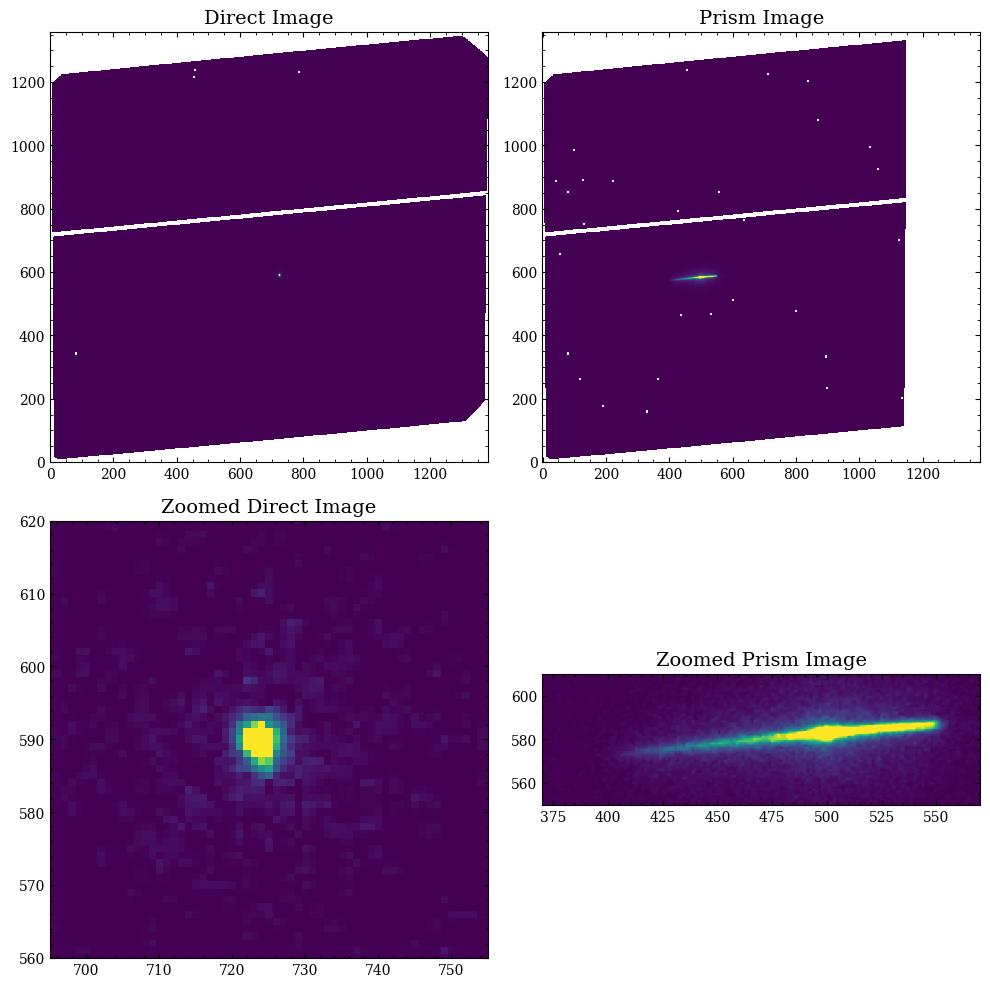

In [10]:
os.chdir(cwd)

fig, axes = plt.subplots(2, 2, figsize=(10,10))

img = fits.getdata(os.path.join(band, f'{band}_drz.fits'))
_ = axes[0][0].imshow(img, origin="lower", vmin=0, vmax=1)
_ = axes[1][0].imshow(img, origin="lower", vmin=0, vmax=1)
axes[1][0].set_xlim(725-30, 725+30)
axes[1][0].set_ylim(590-30, 590+30)

axes[0][0].set_title('Direct Image')
axes[1][0].set_title('Zoomed Direct Image')


pri = fits.getdata(os.path.join(grating, f'{grating}_drz.fits'))
_ = axes[0][1].imshow(pri,origin="lower", vmin=0, vmax=1)
_ = axes[1][1].imshow(pri,origin="lower", vmin=0, vmax=1)
axes[1][1].set_xlim(370,570)
axes[1][1].set_ylim(550,610)
axes[0][1].set_title('Prism Image')
axes[1][1].set_title('Zoomed Prism Image')



## Make a Source Catalog

We need a source catalog to pass to `hstaxe`, which is most easily made using `SExtractor`.  But we must rename the magnitude field to be `MAG_F1650`, where the number `F1650` is approximately the central wavelength of the direct image in angstroms.  This cell will also create a *segmentation map*, which is not required by `HSTaXe` but it can occasionally be useful in understanding some aspects of `SExtractor`.

### things to take special note of
1.  This step obviously requires `SExtractor`, you should consider installing that now
2.  We must set the `F` before the central wavelength.
3.  Use the AB-magnitude zeropoint for the direct image (for the F165LP data this is 21.221)
4.  We will use `SExtractor`'s default settings (so it is safe to ignore the warning message from `SExtractor`)
5.  You will likely get a `SExtractor` warning that the image contains mostly constant data, which arises from the fact that the SBC has effectively no sky background and the image is all zero.  This can be safely ignored.

In [11]:
# go to the base directory and then move to the direct image directory
os.chdir(cwd)
os.chdir(band)

# the zeropoint
zero = 21.221            # in AB magnitudes
tmpcat = 'test.cat'      # temporary catalog that will be overwritten by changing the MAG_AUTO field (see above)
catfile = f'{band}.cat'  # the actual catalog that we will use

# create the parameters we will have SExtractor measure
with open('default.param','w') as fp:
    for k in ('X_IMAGE','Y_IMAGE','NUMBER','X_WORLD','Y_WORLD','A_IMAGE','B_IMAGE','THETA_IMAGE','A_WORLD','B_WORLD','THETA_WORLD','FLUX_RADIUS','MAG_AUTO','MAGERR_AUTO'):
        print(k,file=fp)
        
# we must copy the SExtractor convolution kernel to the local directory.  Assuming SExtractor and it's 
# files are installed in the user's home directory, then the file can be copied to the cwd with:
shutil.copyfile(os.path.join(os.path.expanduser("~"),'sextractor','config','default.conv'), 'default.conv')

# now run SExtractor.
os.system(f'sex -c default.sex {band}_drz.fits[1] -DETECT_THRESH 1 -MAG_ZEROPOINT {zero} -CATALOG_NAME {tmpcat} -VERBOSE_TYPE QUIET -CHECKIMAGE_TYPE segmentation -CHECKIMAGE_NAME {band}_seg.fits')


# open the tmpcat, change the header name
with open(tmpcat,'r') as fin, open(catfile,'w') as fout:
    for line in fin:
        if line[6:15] == 'MAG_AUTO ':
            line=line[:6]+f'MAG_F{wave}'+line[15:]
                
        print(line,file=fout,end='')
        
# remove the tmp catalog
os.remove(tmpcat)


> WARNING: default.sex not found, using internal defaults


> WARNING: Image contains mainly constant data; I'll try to cope with that...



## Set up aXe

`hstaxe` is the Python front-end to the `aXe` package, which expects several directories to place output products.  This cell will create the relevant directories.

### things to take special note of
1. The `AXE_OUTPUT_PATH` variable must be less than 80 characters!

In [12]:
os.chdir(cwd)
import os

if os.path.isdir("DATA"):
    shutil.rmtree("DATA")
os.mkdir("DATA")
os.environ['AXE_IMAGE_PATH'] = os.path.join(cwd, 'DATA')+os.sep 
print (f'--> variable AXE_IMAGE_PATH   set to {os.environ["AXE_IMAGE_PATH"]}')

os.environ['AXE_CONFIG_PATH'] = os.path.join(cwd, 'CONF')+os.sep
print (f'--> variable AXE_CONFIG_PATH  set to {os.environ["AXE_CONFIG_PATH"]}')

if os.path.isdir("OUTPUT"):
    shutil.rmtree("OUTPUT")
os.mkdir("OUTPUT")
os.environ['AXE_OUTPUT_PATH'] = os.path.join(cwd, 'OUTPUT')+os.sep
print (f'--> variable AXE_OUTPUT_PATH  set to {os.environ["AXE_OUTPUT_PATH"]}')

if os.path.isdir("DRIZZLE"):
    shutil.rmtree("DRIZZLE")
os.mkdir("DRIZZLE")
os.environ['AXE_DRIZZLE_PATH'] = os.path.join(cwd, 'DRIZZLE')+os.sep 
print (f'--> variable AXE_DRIZZLE_PATH set to {os.environ["AXE_DRIZZLE_PATH"]}')

os.mkdir(os.path.join("DRIZZLE","tmp"))

print (f"Length of AXE_IMAGE_PATH is {len(os.environ['AXE_IMAGE_PATH'])} characters")



--> variable AXE_IMAGE_PATH   set to /Users/rryan/ACS/SBC/example/hstaxe/DATA/
--> variable AXE_CONFIG_PATH  set to /Users/rryan/ACS/SBC/example/hstaxe/CONF/
--> variable AXE_OUTPUT_PATH  set to /Users/rryan/ACS/SBC/example/hstaxe/OUTPUT/
--> variable AXE_DRIZZLE_PATH set to /Users/rryan/ACS/SBC/example/hstaxe/DRIZZLE/
Length of AXE_IMAGE_PATH is 41 characters


In [13]:
# aXe will only look within the spectroscopic image within a certain range.  Set that range here:
dimension_info = "0,0,0,0"


In [14]:
# copy the data into the DATA dir
os.chdir(cwd)

for g in grating_files:
    shutil.copyfile(os.path.join(grating, g), os.path.join('DATA', g))

for b in band_files:
    shutil.copyfile(os.path.join(band, b), os.path.join('DATA', b))
    

## Start Running aXe

The first step is to prep the catalogs by tranforming the (x,y)-coordinates from the master mosaic that we found using `SExtractor` to the (x,y)-coordinates in each fo the direct image(s).   This is fast.

In [15]:
# always start in the home dir
os.chdir(cwd)
os.chdir(band)

# call the axe code:
hstaxe.axetasks.iolprep(drizzle_image=f'{band}_drz.fits',
                 input_cat=f'{band}.cat',
                 dimension_in=dimension_info)


# now we must pair those output catalogs with their images.  start by copying the files to the DATA directory
for c in glob.glob(os.path.join('j????????_flt_?.cat')):
    shutil.copyfile(c, os.path.join('..','DATA', c))

# pair the files in the `axe.lis` file.  This is complicated to script, so we'll do it by hand.
# the columns of this file are given as:
# 1: spectroscopic image
# 2: direct-image based catalog
# 3: direct image
os.chdir(cwd)

axelis = 'aXe.lis'

with open(axelis,'w') as fp:
    print('j97b08klq_flt.fits j97b08kjq_flt_1.cat j97b08kjq_flt.fits',file=fp)
       

## Run aXe on the spectroscopic images

This will require the grism/prism reference file, which should be downloaded separately for each instrument.  For this notebook, one needs the `ACS.SBC.PR130L.Cycle13.conf` file.

This cell does most of the work of spectral extraction, and is broken into two substeps.  The first substep (`axeprep`) computes all the transformations between the spectroscopic and direct image pixels, which is written into a fits table for faster access in later steps.  The second sub-step (`axecore`) groups various elements from the fits table as a function of wavelength, folding in aspects of the cross-dispersion profile, estimating the contamination based on other sources, and much more.   Naturally, there are many parameters that govern these actions, so we refer the reader to the [hstaxe documentation](https://hstaxe.readthedocs.io/en/latest/) for more details.

After extraction, we will be comparing to the published spectra from [Larsen (2006)](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr0602.pdf), who used an extraction box of 17 pix in width.  The width is set by a multiplicative factor of the FWHM in the `extrfwhm` keyword.  The encircled energy for the SBC reaches 50% at $\sim\!0.6"$ (see the [Fig 5.12 of the ACS Handbook](https://www.stsci.edu/files/live/sites/www/files/home/hst/documentation/_documents/acs/acs_ihb_cycle18.pdf)), and the pixel scale for SBC is 0.03 "/pix.  Therefore the multiplicative factor is:

$\frac{R_{\rm Larsen}}{(FWHM/pixscl)} = \frac{17\mathrm{pix}}{0.06"/(0.03\mathrm{"/pix})} = 8.5$


### things to take special note of
1.  For the ACS/SBC, there is effectively no sky background.  Therefore we must skip the background-subtraction step in `aXe`, so we set `backgr=False`.
2.  This is the majority of the work for spectral extraction, as such it can be slow.

In [16]:
# as always
os.chdir(cwd)
conffile = 'ACS.SBC.PR130L.Cycle13.conf'


# first substep
try:
    hstaxe.axetasks.axeprep(inlist=axelis,configs=conffile,backgr=False,norm=True,mfwhm=3.)
except:
    pass

# second substep
hstaxe.axetasks.axecore(axelis, conffile, fconfterm=None, extrfwhm=8.5, drzfwhm=3., orient=False,
                        back=False, backfwhm=50., weights=True, slitless_geom=False, cont_model='gauss',
                        sampling='trace', exclude=True)


Writing non-linear coefficients to file: DATA/j97b08klq_flt_coeffs1.dat


Storing non-linear coefficients: 
ACS: SBC

DRZSCALE set to: 0.02500000037252903


## Inspect the Outputs

Here we show the primary output products.  We refer the reader to the ISR: [Larsen (2006)](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr0602.pdf) for a comparison.  But also, compare to the lower right panel in the above figure, the difference is this new figure has been rectified, which results in a flat spectral trace with wavelength increasing as $+x$.

The first figure will be the rectified 2d spectroscopic image.  This can be compared to the lower-panel of Fig 2 in [Larsen (2006)](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr0602.pdf).  The blue data (standard extraction of 17 pix width) in the second figure is directly comparable to the left panel of Fig 3 in [Larsen (2006)](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr0602.pdf).  

### things to make special note of
1.  The first order spectral trace is referred to as "Beam A" in axe.  The output products will be fits files with the `EXTNAME = BEAM_XXXXA`, where "XXXX" is the object ID from the `SExtractor` catalog.

In [17]:
# as always
os.chdir(cwd)

# we have only 1 source, so lets look at that
objid = 1                      # object ID from the SExtractor catalog
dataset='j97b08klq'            # the prism image we want to look at
exten = (f'BEAM_{objid}A', 1)  # the extnsion tuple for the good object

# the output products from hstaxe
f1_STP = os.path.join('OUTPUT',f'{dataset}_flt_2.STP.fits')         # the rectified prism image stamp
f1_SPC = os.path.join('OUTPUT',f'{dataset}_flt_2.SPC.fits')         # the 1d spectra
f1_OPT_SPC = os.path.join('OUTPUT',f'{dataset}_flt_2_opt.SPC.fits') # the 1d spectra with optimal extraction


Shape of the rectified stamp: (21, 204)


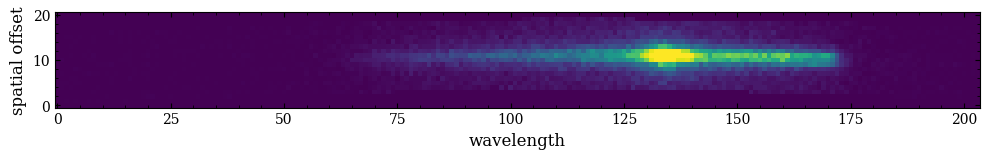

In [18]:
# show the rectified 2d prism image

fig, axis = plt.subplots(1, 1, figsize=(10,5))
img = fits.getdata(f1_STP, ext=exten)
_ = axis.imshow(img, origin='lower', vmin=0, vmax=2)
axis.set_xlabel('wavelength')
axis.set_ylabel('spatial offset')

print(f'Shape of the rectified stamp: {img.shape}')

# Nota bene: although the x-axis maps directly to wavelength in this image, the mapping is quite complex 
#            due to the non-linear nature of prism spectral elements.  In general, the wavelength is 
#            characterized as a Laurent polynomial in 'x'.



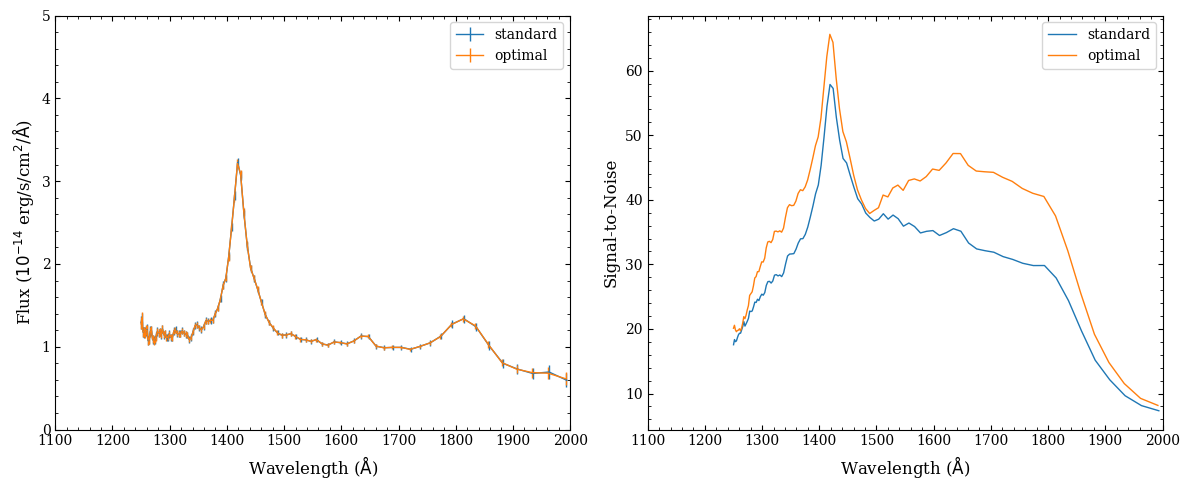

In [19]:
# show the 1d spectra
fig, (a1,a2) = plt.subplots(1, 2, sharex=True, figsize=(12,5))
fluxunit = 1e-14

# read the data
dat1 = fits.getdata(f1_SPC, ext=exten)
dat2 = fits.getdata(f1_OPT_SPC, ext=exten)

# get a useful range
g1 = (1250. < dat1['LAMBDA']) & (dat1['LAMBDA'] < 2000.)
a1.errorbar(dat1['LAMBDA'][g1], dat1['FLUX'][g1]/fluxunit, dat1['FERROR'][g1]/fluxunit, label='standard')

g2 = (1250. < dat2['LAMBDA']) & (dat2['LAMBDA'] < 2000.)
a1.errorbar(dat2['LAMBDA'][g2], dat2['FLUX'][g2]/fluxunit, dat2['FERROR'][g2]/fluxunit, label='optimal')

a1.set_xlabel(r'Wavelength ($\mathrm{\AA}$)')
a1.set_ylabel(r'Flux ($10^{-14}$ erg/s/cm$^2/\mathrm{\AA}$)')
a1.set_xlim(1100, 2000)
a1.set_ylim(0, 5)
a1.legend()


a2.plot(dat1['LAMBDA'][g1], dat1['FLUX'][g1]/dat1['FERROR'][g1], label='standard')
a2.plot(dat2['LAMBDA'][g2], dat2['FLUX'][g2]/dat2['FERROR'][g2], label='optimal')
a2.set_xlabel(r'Wavelength ($\mathrm{\AA}$)')
a2.set_ylabel(r'Signal-to-Noise')

a2.legend()


      

## Conclusions

### Comparisons of aXe products.

The flux between the boxcar extraction (blue) and the optimal extraction (orange; see the method of [Horne 1986](https://ui.adsabs.harvard.edu/abs/1986PASP...98..609H/abstract)) in the last figure is very minor (see left panel).  However, the optimal method should generally produce a higher signal-to-noise, as shown in the right panel.  Nevertheless, users should only expect this performance increase when the source profile is well understood and easily measured.  Because, when this is not true, one should expect systematic biases between the measured and true signal.


**This concludes the demonstration of `hstaxe` with the ACS/SBC for PR130L.**


### Additional Work for the Reader

This work can be extended in two ways:
1.  There are observations in PR110L as well.  This is a trivial exercise of identifying the dataset names and redoing the notebook with those files. In this case, one will require the calibration file for the PR110L prism (`ACS.SBC.PR110L.Cycle13.conf`).  

2.  There are multiple observations (at different detector positions) in both PR110L and PR130L, which were used to calibrate the field dependence of various aspects.  These data could be used to improve the S/N of the final extraction, however `hstaxe` does not provide facility to combine the spectra taken at different position angles (PAs).  Therefore, one extracts the 1d spectra at each unique PA separately and *post facto* combines them according to whatever method they wish (e.g. sigma-clipped, variance-weighted average).  However, this process can be tricky for extended sources, where the spectral resolution for differ between the PAs.  This is because the spectral resolution will depend on the "extent" of the galaxy projected along the dispersion axis, in analogy to the relationship between slit-width and spectral resolution in classic, slit-based spectroscopy.  Please see [Ryan, Casertano, & Pirzkal (2018)](https://ui.adsabs.harvard.edu/abs/2018PASP..130c4501R/abstract) for more information on techniques for combining data at multiple position angles.
